# Proyecto entrega 1

### Integrantes
* Santiago Gomez
* Sebastian Martinez
* Johan Suarez

### Grupo
36

## Carga de datos

In [2]:
%pip install -U "spacy>=3.8,<3.9"
%pip install "./es_core_news_sm-3.8.0-py3-none-any.whl" 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\jcsua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Processing d:\bi\proyecto-1\es_core_news_sm-3.8.0-py3-none-any.whl
es-core-news-sm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\jcsua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

vectorizer = TfidfVectorizer()
nlp = spacy.load("es_core_news_sm")
dfOriginal = pd.read_excel('Datos_proyecto.xlsx')
dfOriginal.info()
targetNames = dfOriginal['labels'].unique()
print("Categorías encontradas:", targetNames)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB
Categorías encontradas: [4 3 1]


## Exploración del texto

Principalmente observemos el formato inicial del dataset, con especial enfasis en la columna de textos

In [4]:
targetNames =  {1:'ODS 1',3:'ODS 3',4:'ODS 4'}
dfOriginal.head()
df = dfOriginal.copy()
df['textos'] = df['textos'].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   string
 1   labels  2424 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 38.0 KB


### Exploracion de longitudes de los textos presentados en el dataset

In [5]:
def columnasConteo(df : pd.DataFrame):
    df['Conteo'] = [len(x) for x in df['textos']]
    df['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in df['textos']]
    df['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in df['textos']]
columnasConteo(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,Para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"Además, la formación de especialistas en medic...",3,659,15,1
3,En los países de la OCDE se tiende a pasar de ...,4,693,18,1
4,Este grupo se centró en las personas que padec...,3,608,14,0


Veamos ahora los maximos, minimos y promedio de la longitud de los textos del dataset

In [6]:
def longitud(df: pd.DataFrame):
    maximo = df['Conteo'].max()
    minimo = df['Conteo'].min()
    promedio = int(df['Conteo'].mean())
    print(f'El maximo de longitud es: {maximo}')
    print(f'El minimo de longitud es: {minimo}')
    print(f'El promedio de longitud es: {promedio:.2f}')
    return maximo, minimo, promedio

El maximo de longitud es: 1492
El minimo de longitud es: 303
El promedio de longitud es: 683.00


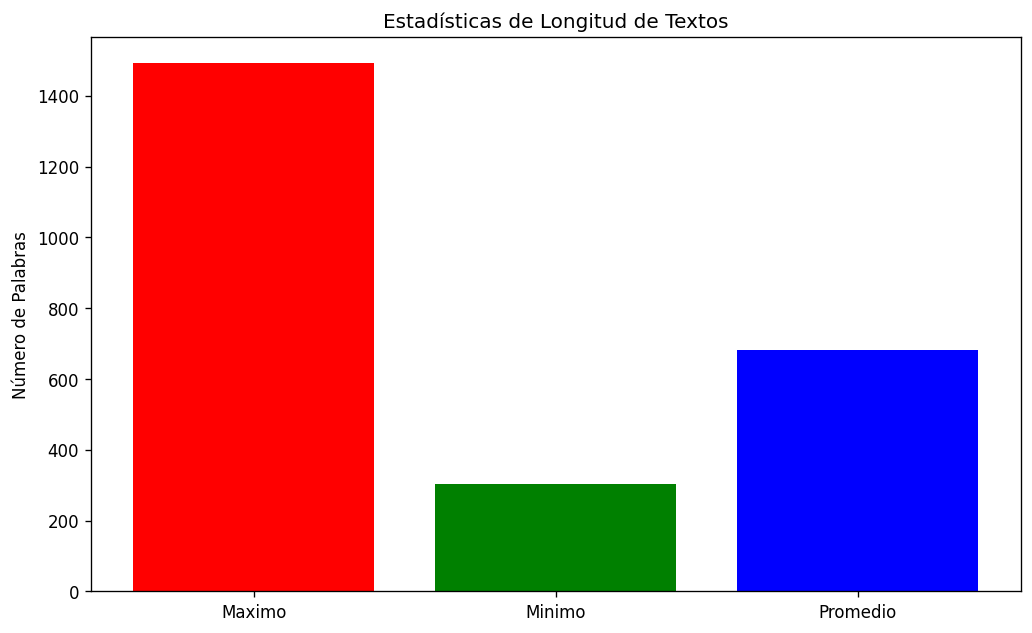

In [7]:
maximo, minimo, promedio = longitud(df)
plt.figure(figsize=(10,6))
plt.bar(['Maximo', 'Minimo', 'Promedio'], [maximo, minimo, promedio], color=['red', 'green', 'blue'])
plt.title('Estadísticas de Longitud de Textos')
plt.ylabel('Número de Palabras')
plt.show()


### Distribucion de la longitud

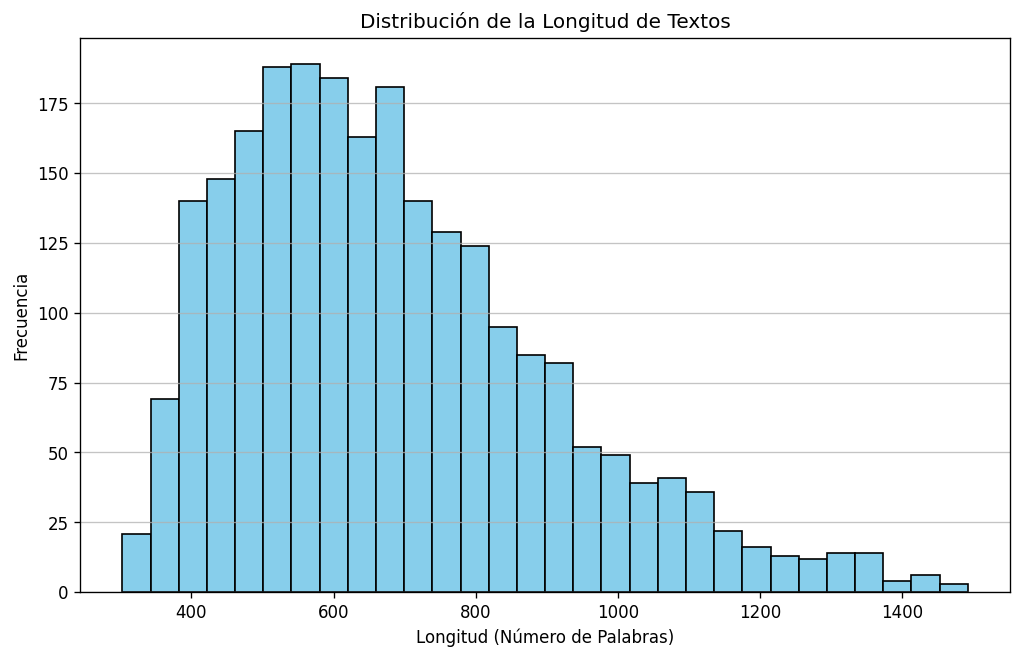

In [8]:

plt.figure(figsize=(10,6))
plt.hist(df['Conteo'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de Textos')
plt.xlabel('Longitud (Número de Palabras)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

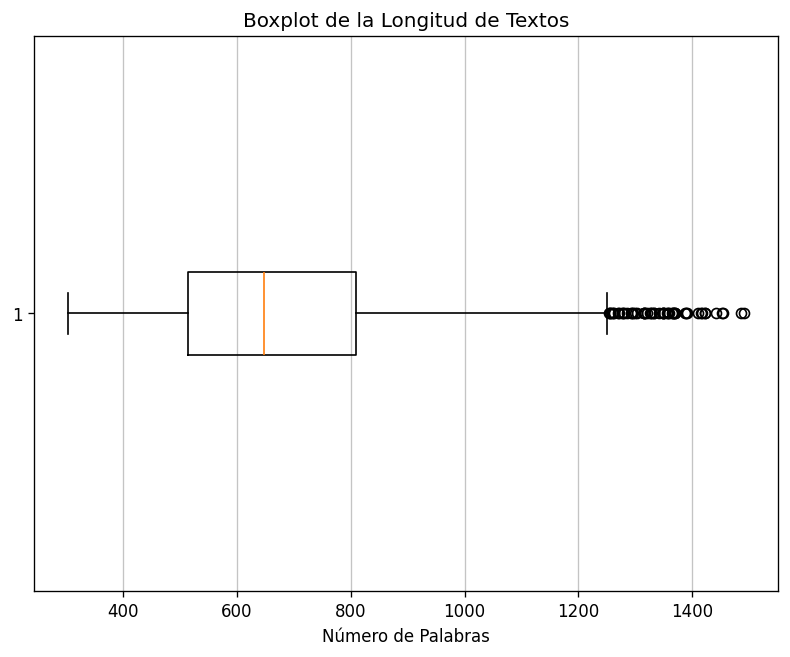

In [9]:
#Boxplot
plt.figure(figsize=(8,6))
plt.boxplot(df['Conteo'], vert=False)
plt.title('Boxplot de la Longitud de Textos')
plt.xlabel('Número de Palabras')
plt.grid(axis='x', alpha=0.75)
plt.show()

### Presencia de catracteres especiales

In [10]:
def especiales(df : pd.DataFrame):
    signos = r"(?:[!¡¿?;:'\"]|\.{3})"
    signosPresentes = df['textos'].str.contains(signos).sum()
    print(f'La cantidad de textos con signos de puntuación es: {signosPresentes}')
    print(f'El porcentaje de textos con signos de puntuación es: {signosPresentes/len(df)*100:.2f}%')
    especiales = r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])"
    especialesPresentes = df['textos'].str.contains(especiales).sum()
    print(f'La cantidad de textos con caracteres especiales es: {especialesPresentes}')
    print(f'El porcentaje de textos con caracteres especiales es: {especialesPresentes/len(df)*100:.2f}%')
    return signosPresentes, especialesPresentes


La cantidad de textos con signos de puntuación es: 596
El porcentaje de textos con signos de puntuación es: 24.59%
La cantidad de textos con caracteres especiales es: 1562
El porcentaje de textos con caracteres especiales es: 64.44%


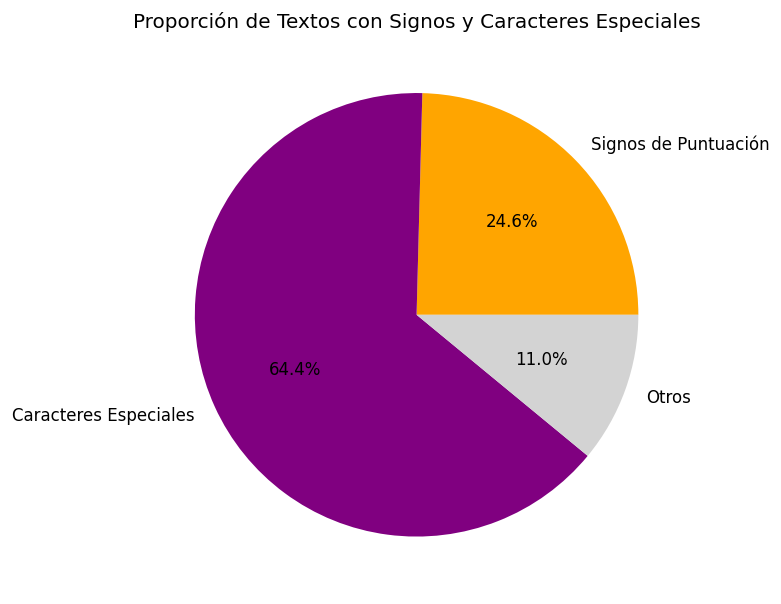

In [11]:
#Distribucion especiales
size = df['textos'].size
signosPresentes, especialesPresentes = especiales(df)
plt.figure(figsize=(8,6))
plt.pie([signosPresentes, especialesPresentes, size - signosPresentes - especialesPresentes], labels=['Signos de Puntuación', 'Caracteres Especiales', 'Otros'], autopct='%1.1f%%', colors=['orange', 'purple', 'lightgray'])
plt.title('Proporción de Textos con Signos y Caracteres Especiales')
plt.show()


### Distribucion de labels

,conteo
ODS 1,505
ODS 3,894
ODS 4,1025


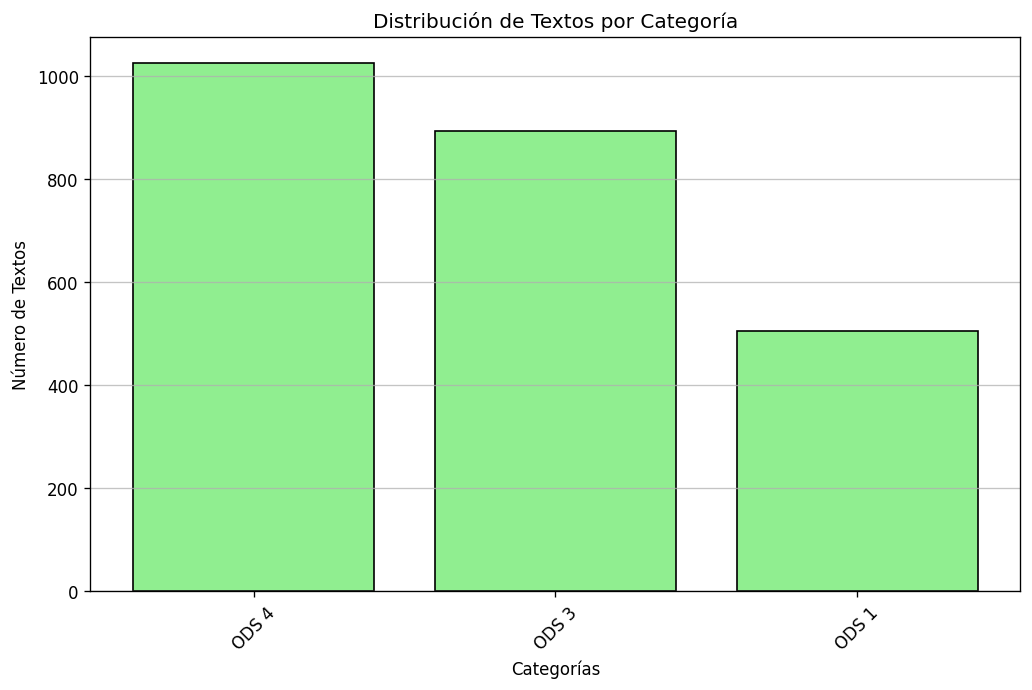

In [12]:
tiposComentario = df['labels'].value_counts().sort_index()
tiposComentario.index = [targetNames[i] for i in tiposComentario.index]
display(tiposComentario.to_frame('conteo'))

labelContador = df['labels'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(labelContador.index.map(targetNames), labelContador.values, color='lightgreen', edgecolor='black')
plt.title('Distribución de Textos por Categoría')
plt.xlabel('Categorías')
plt.ylabel('Número de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


<Figure size 1200x720 with 0 Axes>

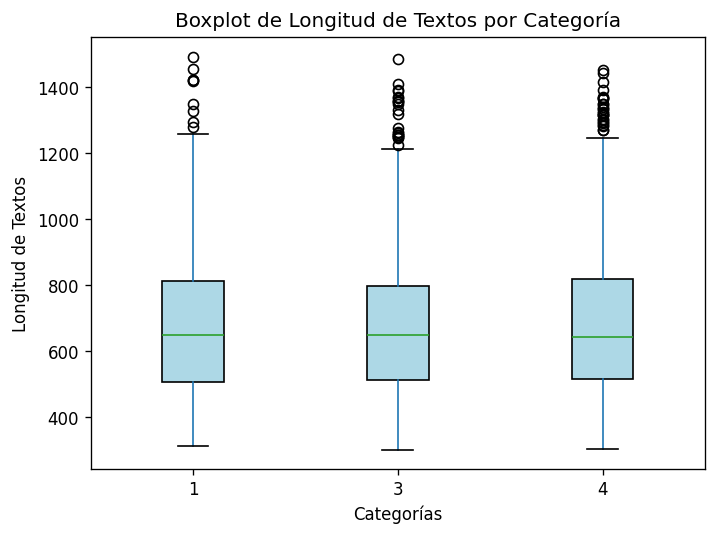

In [13]:
#Boxplot por categoria
plt.figure(figsize=(10,6))
df.boxplot(column='Conteo', by='labels', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Longitud de Textos por Categoría')
plt.suptitle('')  
plt.xlabel('Categorías')
plt.ylabel('Longitud de Textos')
plt.show()

### Limpieza

Procedemos a poner todo el dataset en un único formato

In [14]:
def todoAmin(df: pd.DataFrame):
    df['textos'] = df['textos'].str.lower()
todoAmin(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"además, la formación de especialistas en medic...",3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


Limpieza de caracteres especiales, signos y urls

In [15]:
def limpiza(df: pd.DataFrame):
    df['textos'] = df['textos'].str.replace(r"http[s]?://[^\s)]+", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[!¡¿?;:'\".,]|\.{3})", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"\s+", ' ', regex=True).str.strip()
limpiza(df)
df.head()


,textos,labels,Conteo,Max,Min
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1
2,además la formación de especialistas en medici...,3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


### Duplicados y Nulos

In [16]:
#Codigo dado en el notebook de la clase
def verNulosYDuplicados(df: pd.DataFrame):
    print("Valores nulos por columna:")
    display(df.isnull().sum())
    print("\nDuplicados (filas completas):", df.duplicated().sum())
    const_cols = [c for c in df.columns if df[c].nunique() == 1]
    print("Columnas constantes:", const_cols if const_cols else "Ninguna")
verNulosYDuplicados(df)

Valores nulos por columna:


textos    0
labels    0
Conteo    0
Max       0
Min       0
dtype: int64


Duplicados (filas completas): 0
Columnas constantes: Ninguna


### Tokenización

In [17]:
def tokenizacion(df: pd.DataFrame):
    columnaTokens = []
    for opinion in df['textos']:
        columnaTokens.append(opinion.split())
    df['tokens'] = columnaTokens
    return df
doc = tokenizacion(df)   
df.head()

,textos,labels,Conteo,Max,Min,tokens
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q..."


### Eliminación de tockens innecesarios, articulos, preposiciones, etc.

In [18]:
def quitar_stopwords(df: pd.DataFrame):
    stopwords = nlp.Defaults.stop_words
    tokensSinStopwords = []
    
    for lista in df['tokens']:
        tokens_filtrados = [tok for tok in lista if tok.lower() not in stopwords]
        tokensSinStopwords.append(tokens_filtrados)

    df['tokens_sin_innecesarios'] = tokensSinStopwords

quitar_stopwords(df)
df.head()


,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,..."


### Lematización

In [19]:
def lematizar_tokens(df: pd.DataFrame):
    lemas = []
    for lista in df['tokens_sin_innecesarios']:

        texto = " ".join(lista)
        doc = nlp(texto)
        lemas.append([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    
    df['lematizados'] = lemas
    return df

df = lematizar_tokens(df)
df.head()

,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios,lematizados
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ...","[formación, especialista, medicín, general, in..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ..."


### Analisis de frecuencia de palabras

In [20]:
def frecuenciasPorPalabra(df: pd.DataFrame, vectorizer=vectorizer):
    textos = [" ".join(tokens) for tokens in df['lematizados']]
    X = vectorizer.fit_transform(textos)
    palabras = vectorizer.get_feature_names_out()
    pesosPromedio = np.asarray(X.mean(axis=0)).ravel()
    freq_df = pd.DataFrame({'Palabra': palabras, 'Peso Promedio': pesosPromedio})
    freq_df = freq_df.sort_values(by='Peso Promedio', ascending=False).reset_index(drop=True)
    return freq_df

freq_df = frecuenciasPorPalabra(df)
freq_df.head(10)


,Palabra,Peso Promedio
0,salud,0.027882
1,educación,0.025477
2,país,0.025256
3,escuela,0.024556
4,atención,0.024052
5,pobreza,0.022993
6,sistema,0.018521
7,año,0.018438
8,nivel,0.018389
9,servicio,0.017348


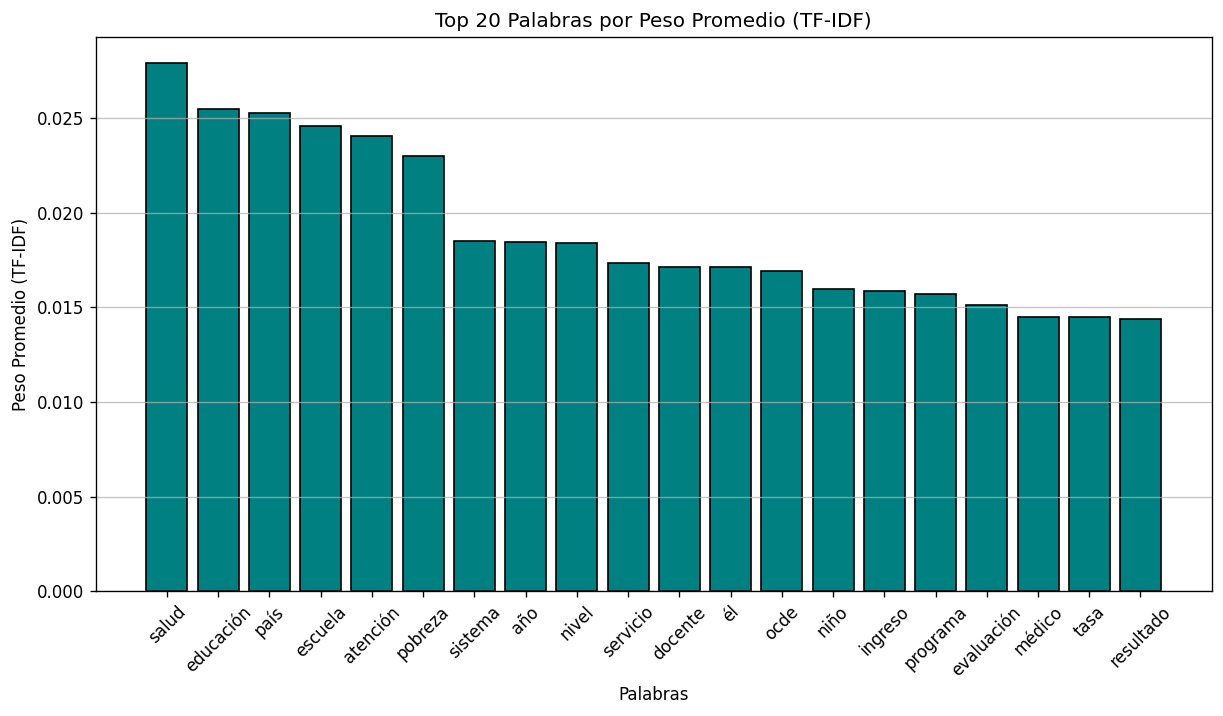

In [21]:
#plot frecuencias
plt.figure(figsize=(12,6))
plt.bar(freq_df['Palabra'][:20], freq_df['Peso Promedio'][:20], color='teal', edgecolor='black')
plt.title('Top 20 Palabras por Peso Promedio (TF-IDF)')
plt.xlabel('Palabras')
plt.ylabel('Peso Promedio (TF-IDF)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

Tamaños -> train: 1696 | valid: 243 | test: 485

Búsqueda de C en VALIDACIÓN:
C=0.1  | F1-macro (valid)=0.9817
C=0.5  | F1-macro (valid)=0.9817
C=1    | F1-macro (valid)=0.9817
C=2    | F1-macro (valid)=0.9817
C=5    | F1-macro (valid)=0.9817
C=10   | F1-macro (valid)=0.9817

>> Mejor C en validación: 0.1 | F1-macro (valid)=0.9817

=== Classification Report (TRAIN+VALID 80%) ===
              precision    recall  f1-score   support

       ODS 1       0.99      1.00      0.99       404
       ODS 3       1.00      1.00      1.00       715
       ODS 4       1.00      1.00      1.00       820

    accuracy                           1.00      1939
   macro avg       1.00      1.00      1.00      1939
weighted avg       1.00      1.00      1.00      1939



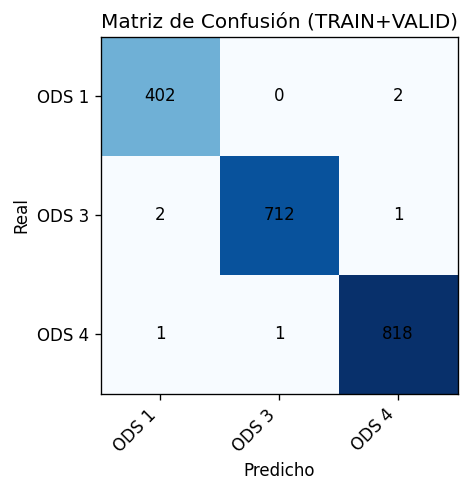


=== Classification Report (TEST 20%) ===
              precision    recall  f1-score   support

       ODS 1       0.96      0.93      0.94       101
       ODS 3       0.96      0.97      0.97       179
       ODS 4       0.97      0.98      0.97       205

    accuracy                           0.96       485
   macro avg       0.96      0.96      0.96       485
weighted avg       0.96      0.96      0.96       485



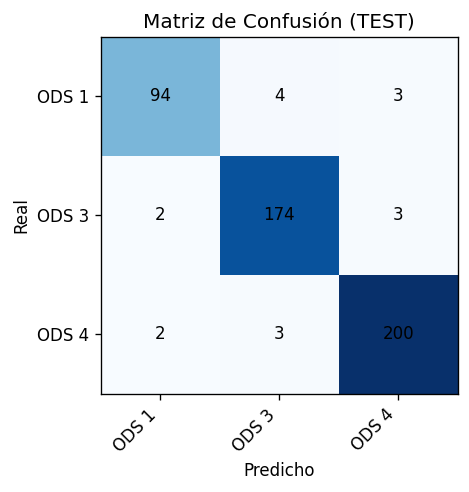

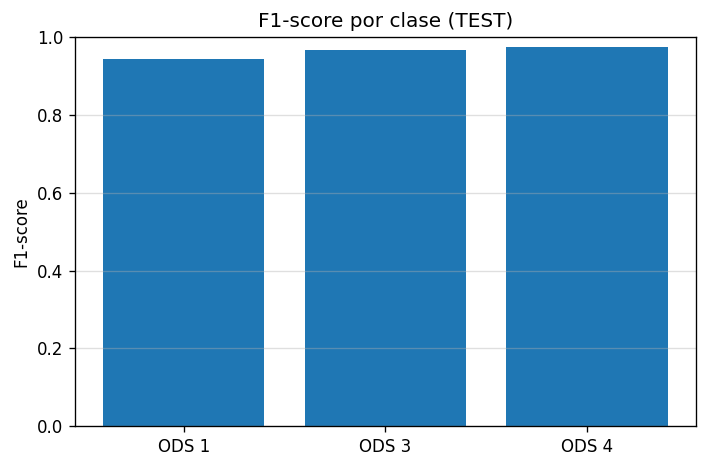

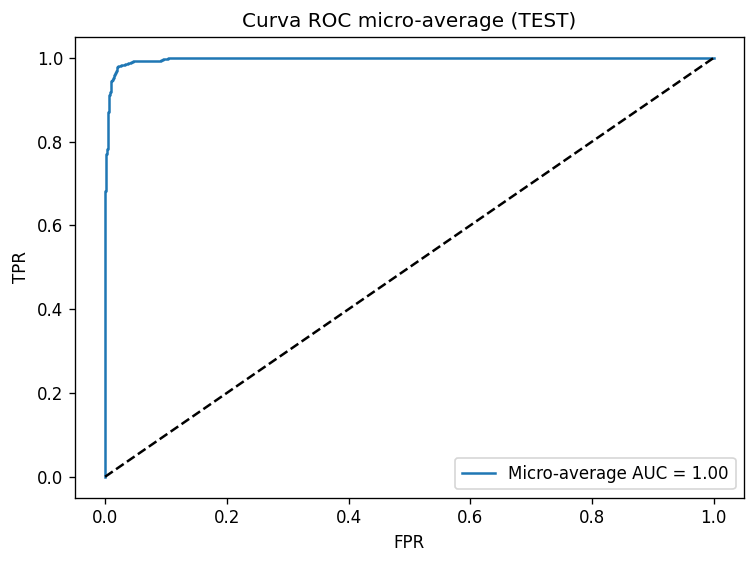


Top 15 términos para ODS 1


,clase,termino,peso
0,ODS 1,pobreza,3.213725
1,ODS 1,pobre,1.827573
2,ODS 1,pobrezar,1.485738
3,ODS 1,hogar,1.267473
4,ODS 1,ingreso,1.215667
5,ODS 1,privacion,0.917140
6,ODS 1,social,0.862069
7,ODS 1,proteccion social,0.798667
8,ODS 1,proteccion,0.714021
9,ODS 1,transferencia,0.625864


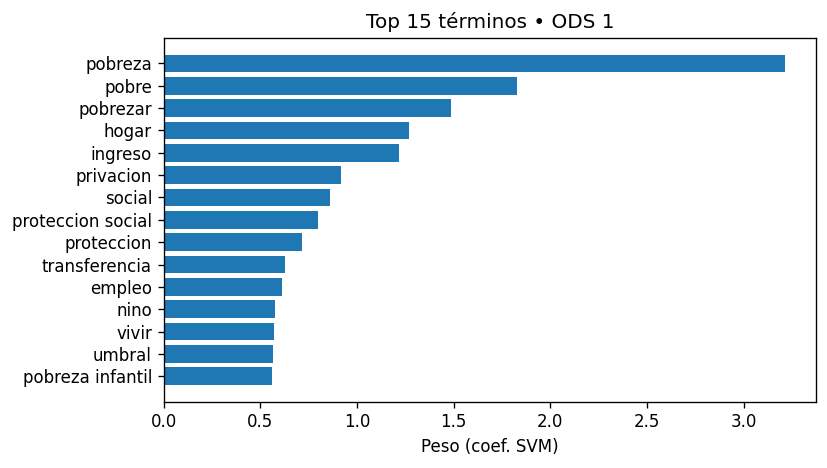


Top 15 términos para ODS 3


,clase,termino,peso
0,ODS 3,salud,2.407623
1,ODS 3,atencion,1.453267
2,ODS 3,medico,1.419616
3,ODS 3,paciente,1.214076
4,ODS 3,enfermedad,1.174500
5,ODS 3,sanitario,1.118342
6,ODS 3,mental,0.791013
7,ODS 3,tratamiento,0.761085
8,ODS 3,hospital,0.756212
9,ODS 3,mortalidad,0.751749


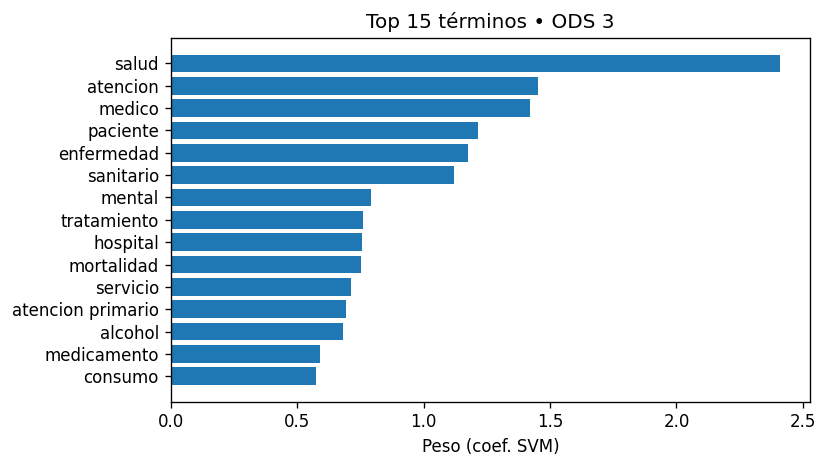


Top 15 términos para ODS 4


,clase,termino,peso
0,ODS 4,educacion,1.920794
1,ODS 4,escuela,1.836565
2,ODS 4,educativo,1.266217
3,ODS 4,docente,1.231352
4,ODS 4,estudiant,1.213785
5,ODS 4,aprendizaje,1.201783
6,ODS 4,escolar,1.138506
7,ODS 4,alumno,1.052383
8,ODS 4,estudiante,0.886665
9,ODS 4,profesor,0.854640


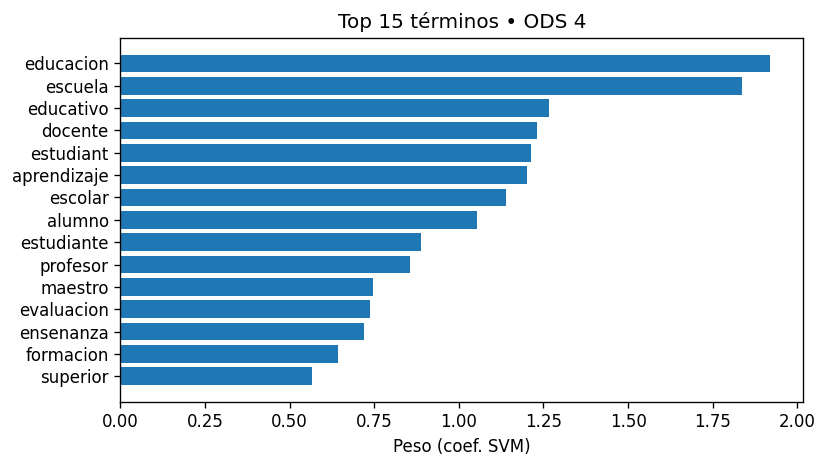


CSV de resultados guardado en: resultados_svm_tfidf_70_10_20.csv


In [22]:
# === TF-IDF (palabras) + LinearSVC con VALIDACIÓN 10% y TEST 20% (métricas completas + TOP términos + CSV) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

plt.rcParams["figure.dpi"] = 120

# ---- util: nombre bonito de clase si existe targetNames ----
def nombre_clase(c):
    try:
        return targetNames.get(c, str(c))   # en tu notebook: {1:'ODS 1',3:'ODS 3',4:'ODS 4'}
    except Exception:
        return str(c)

# 1) Textos y etiquetas desde tu df ya procesado
textos = [" ".join(t) for t in df["lematizados"]]
labels = df["labels"].values
classes_sorted = np.sort(np.unique(labels))
classes_names  = [nombre_clase(c) for c in classes_sorted]

# ---------------- SPLIT 70/10/20 ----------------
# Primero separamos TEST = 20% del total
X_trainval, X_test, y_trainval, y_test = train_test_split(
    textos, labels, test_size=0.20, random_state=42, stratify=labels
)
# De lo que queda (80%), sacamos VALID = 10% del total => 10/80 = 0.125 del trainval
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.125, random_state=42, stratify=y_trainval
)
print(f"Tamaños -> train: {len(X_train)} | valid: {len(X_valid)} | test: {len(X_test)}")

# 3) TF-IDF (palabras, uni/bi-gramas) — se ajusta SOLO con TRAIN
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    analyzer="word",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    max_features=8000
)
Xtr = tfidf.fit_transform(X_train)
Xva = tfidf.transform(X_valid)
Xte = tfidf.transform(X_test)

# 4) Selección de C en VALIDACIÓN (hold-out, sin GridSearchCV)
C_grid = [0.1, 0.5, 1, 2, 5, 10]
mejor_C, mejor_f1 = None, -1.0
mejor_clf = None
print("\nBúsqueda de C en VALIDACIÓN:")
for C in C_grid:
    clf_tmp = LinearSVC(C=C, class_weight="balanced", random_state=42)
    clf_tmp.fit(Xtr, y_train)
    y_pred_valid = clf_tmp.predict(Xva)
    f1M_valid = f1_score(y_valid, y_pred_valid, average="macro")
    print(f"C={C:<4} | F1-macro (valid)={f1M_valid:.4f}")
    if f1M_valid > mejor_f1:
        mejor_f1 = f1M_valid
        mejor_C = C
        mejor_clf = clf_tmp

print(f"\n>> Mejor C en validación: {mejor_C} | F1-macro (valid)={mejor_f1:.4f}")

# 5) Reentrenar modelo FINAL en TRAIN+VALID (80%) con el mejor C
# Re-ajustamos TF-IDF con TRAIN+VALID para que el vocabulario use el 80% de datos
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    analyzer="word",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    max_features=8000
)
Xtr_final = tfidf.fit_transform(X_train + X_valid)
ytr_final = np.concatenate([y_train, y_valid], axis=0)
Xte_final = tfidf.transform(X_test)

clf = LinearSVC(C=mejor_C, class_weight="balanced", random_state=42)
clf.fit(Xtr_final, ytr_final)

# 6) Predicciones en TRAIN+VALID (80%) y TEST (20%)
y_pred_trainval = clf.predict(Xtr_final)
y_pred_test     = clf.predict(Xte_final)

# === REPORTE TRAIN+VALID (80%) — “TRAIN” en este esquema ===
print("\n=== Classification Report (TRAIN+VALID 80%) ===")
print(classification_report(ytr_final, y_pred_trainval, target_names=classes_names))
cm_train = confusion_matrix(ytr_final, y_pred_trainval, labels=classes_sorted)
fig, ax = plt.subplots(figsize=(5.6, 4.2))
ax.imshow(cm_train, cmap="Blues")
ax.set_title("Matriz de Confusión (TRAIN+VALID)")
ax.set_xticks(range(len(classes_sorted))); ax.set_yticks(range(len(classes_sorted)))
ax.set_xticklabels(classes_names, rotation=45, ha="right"); ax.set_yticklabels(classes_names)
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        ax.text(j, i, cm_train[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
plt.tight_layout(); plt.show()

# === REPORTE TEST (20%) — evaluación final ===
print("\n=== Classification Report (TEST 20%) ===")
print(classification_report(y_test, y_pred_test, target_names=classes_names))
cm_test = confusion_matrix(y_test, y_pred_test, labels=classes_sorted)
fig, ax = plt.subplots(figsize=(5.6, 4.2))
ax.imshow(cm_test, cmap="Blues")
ax.set_title("Matriz de Confusión (TEST)")
ax.set_xticks(range(len(classes_sorted))); ax.set_yticks(range(len(classes_sorted)))
ax.set_xticklabels(classes_names, rotation=45, ha="right"); ax.set_yticklabels(classes_names)
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, cm_test[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
plt.tight_layout(); plt.show()

# === F1 por clase (TEST) ===
_, _, f1_por_clase, _ = precision_recall_fscore_support(y_test, y_pred_test, labels=classes_sorted)
plt.figure(figsize=(6,4))
plt.bar(classes_names, f1_por_clase)
plt.title("F1-score por clase (TEST)")
plt.ylabel("F1-score"); plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.4)
plt.tight_layout(); plt.show()

# === Curva ROC + AUC (TEST) ===
scores = clf.decision_function(Xte_final)
y_test_bin = label_binarize(y_test, classes=classes_sorted)
if y_test_bin.shape[1] == 1:
    fpr, tpr, _ = roc_curve(y_test_bin, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], "k--")
    plt.title("Curva ROC (TEST)")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()
else:
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), np.atleast_2d(scores).ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Micro-average AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], "k--")
    plt.title("Curva ROC micro-average (TEST)")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()

# === TOP términos por clase (coeficientes del SVM, modelo FINAL) ===
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_
top_k = 15
tops_frames = []
for pos, cls in enumerate(clf.classes_):
    idx = np.argsort(coefs[pos])[::-1][:top_k]
    df_top = pd.DataFrame({
        "clase": nombre_clase(cls),
        "termino": feature_names[idx],
        "peso": coefs[pos][idx]
    })
    tops_frames.append(df_top)
    print(f"\nTop {top_k} términos para {nombre_clase(cls)}")
    display(df_top)
    # barplot
    plt.figure(figsize=(7,4))
    plt.barh(df_top["termino"][::-1], df_top["peso"][::-1])
    plt.title(f"Top {top_k} términos • {nombre_clase(cls)}")
    plt.xlabel("Peso (coef. SVM)")
    plt.tight_layout(); plt.show()

# === CSV con resultados del TEST (20%) ===
df_out = pd.DataFrame({"texto": X_test, "y_true": y_test, "y_pred": y_pred_test})
sc = np.atleast_2d(scores)
if sc.ndim == 2:
    for j, cls in enumerate(clf.classes_):
        df_out[f"score_{cls}"] = sc[:, j] if sc.shape[1] > 1 else sc[:, 0]
    df_out["score_max"] = sc.max(axis=1)

df_out.to_csv("resultados_svm_tfidf_70_10_20.csv", index=False, encoding="utf-8")
print("\nCSV de resultados guardado en: resultados_svm_tfidf_70_10_20.csv")
